<a href="https://colab.research.google.com/github/cjsdudwls1/Aflatoxin_analysis/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%8B%A4%EC%9A%B4%EC%82%AC%EC%9D%B4%EC%A7%95%2Bdata_split%2B%EC%97%AC%EB%9F%AC_smote_%EB%B9%84%EA%B5%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 사용된 기상항목
- tmprt_150	기온(150CM)
- tmprt_150Top	기온(150CM)최고
- tmprt_150Lwet	기온(150CM)최저
- hd_150	습도(150CM)
- arvlty_300	풍속(300CM)
- arvlty_300Top	최대풍속(300CM)
- afp	강수량
- sunshn_Time	일조시간
- solrad_Qy	일사량
- soil_Mitr_10	토양수분(10CM)

### 데이터 생성 방법
- 통합_LIMS에서 각 건에 대해 주소에 의해 (위도, 경도) 정보 api에서 조회
- 해당 주소가 없으면 상세 -> 넓은 범위로 넓혀가면서 조회
- 해당 (위도, 경도)와 가장 가까운 관측소를 찾아 해당일 기준 과거 30일 상기 기상항목을 record 형태로 만듦
- 혹시 필요할지 몰라 X에 이런 항목도 추가했음
    - INSPCT_PURPS_NAME
    - INSPCT_KND_NAME
    - PRDLST_NM
    - SPLORE_STTUS_NAME
    - ORGPLCE_NATION_CODE

### 데이터 읽는 방법
df_통합_LIMS_기상정보_결합_y = pd.read_pickle('../results/df_통합_LIMS_기상정보_결합_gzip_y.pkl', compression='gzip')
df_통합_LIMS_기상정보_결합_X = pd.read_pickle('../results/df_통합_LIMS_기상정보_결합_gzip_X.pkl', compression='gzip')

In [ ]:
# !pip install tensorflow -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install xgboost

In [ ]:
import pandas as pd

def summarize(df):
    summary = pd.DataFrame(index=df.columns)
    summary['Data Type'] = df.dtypes
    summary['Unique Values'] = df.nunique()
    summary['Missing Values (%)'] = (df.isnull().sum() / len(df)) * 100

    # Get sample values, up to 10
    def get_sample_values(series):
        non_null_values = series.dropna().unique()
        if len(non_null_values) > 10:
            return non_null_values[:10].tolist()
        else:
            return non_null_values.tolist()

    # Collect sample values for each column
    sample_values_list = [get_sample_values(df[col]) for col in df.columns]
    summary['Sample Values'] = sample_values_list

    return summary

# **1. 데이터 수집 및 전처리**
### 상기실험확임함은 제거
### 가공식품 데이터만 분석대상으로

In [ ]:
import pandas as pd
import numpy as np
# import tensorflow as tf
# from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
# from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# --- 1단계: 데이터 로드 ---
X_df = pd.read_pickle('/content/drive/MyDrive/식약처(아플라톡신 관련 데이터)/250708_통합 LIMS 시험검사 결과(항목 기준)_아플라톡신/_학습용 데이터_/df_통합_LIMS_기상정보_결합_gzip_X.pkl', compression='gzip')
y_df = pd.read_pickle('/content/drive/MyDrive/식약처(아플라톡신 관련 데이터)/250708_통합 LIMS 시험검사 결과(항목 기준)_아플라톡신/_학습용 데이터_/df_통합_LIMS_기상정보_결합_gzip_y.pkl', compression='gzip')

In [ ]:
# Filter out rows where 'JDGMNT_WORD_NAME' is '상기실험확인함'
filtered_indices_jdgmnt = y_df[y_df['JDGMNT_WORD_NAME'] != '상기실험확인함'].index

X_df_filtered = X_df.loc[filtered_indices_jdgmnt]
y_df_filtered = y_df.loc[filtered_indices_jdgmnt]['JDGMNT_WORD_NAME']

# Filter out rows where 'INSPCT_KND_NAME' is '축산물' from the already filtered dataframes
filtered_indices_knd = X_df_filtered[X_df_filtered['INSPCT_KND_NAME'] != '축산물'].index

X_df_filtered = X_df_filtered.loc[filtered_indices_knd]
y_df_filtered  = y_df_filtered.loc[filtered_indices_knd]

print("Filtered X_df shape after removing '상기실험확인함' and '축산물':", X_df_filtered.shape)
print("Filtered y_df shape after removing '상기실험확인함' and '축산물':", y_df_filtered.shape)

X_df_filtered.head()

Filtered X_df shape after removing '상기실험확인함' and '축산물': (130341, 305)
Filtered y_df shape after removing '상기실험확인함' and '축산물': (130341,)


,INSPCT_PURPS_NAME,INSPCT_KND_NAME,PRDLST_NM,SPLORE_STTUS_NAME,ORGPLCE_NATION_CODE,tmprt_150_29,tmprt_150Top_29,tmprt_150Lwet_29,hd_150_29,arvlty_300_29,...,tmprt_150_00,tmprt_150Top_00,tmprt_150Lwet_00,hd_150_00,arvlty_300_00,arvlty_300Top_00,afp_00,sunshn_Time_00,solrad_Qy_00,soil_Mitr_10_00
0,자가품질위탁검사,NaN,과자,냉동,NaN,-5.4,1.3,-10.6,59.3,0.3,...,-4.8,1.9,-9.9,77.9,0.2,2.8,1.0,NaN,3.99,16.1
1,자가품질위탁검사,NaN,과자,냉동,NaN,-5.4,1.3,-10.6,59.3,0.3,...,-4.8,1.9,-9.9,77.9,0.2,2.8,1.0,NaN,3.99,16.1
2,자가품질위탁검사,식품,보스웰리아추출물등 복합물(Flexir)(제2021-9호),실온,NaN,-2.6,3.0,-7.6,55.9,0.7,...,-2.9,5.7,-10.2,79.6,0.6,6.0,0.5,NaN,6.11,NaN
3,자가품질위탁검사,식품,보스웰리아추출물등 복합물(Flexir)(제2021-9호),실온,NaN,-2.6,3.0,-7.6,55.9,0.7,...,-2.9,5.7,-10.2,79.6,0.6,6.0,0.5,NaN,6.11,NaN
4,자가품질위탁검사,식품,과자,NaN,NaN,-1.8,2.7,-7.4,46.9,0.5,...,-2.5,4.4,-8.2,77.2,0.4,4.2,0.0,92.0,4.73,NaN


In [ ]:
y_df_filtered.head()

,JDGMNT_WORD_NAME
0,적합
1,적합
2,적합
3,적합
4,적합


## 2. LIMS와 기후데이터는 원천과 데이터형태(timeseries, cross section data)이니 각각 분리하여 데이터 전처리 수행한다.

In [ ]:
X_lims = X_df_filtered.loc[:, :'ORGPLCE_NATION_CODE']
X_weather = X_df_filtered.loc[:, 'tmprt_150_29':]

In [ ]:
y_df_filtered.value_counts(normalize=True)*100

,proportion
JDGMNT_WORD_NAME,
적합,99.568823
부적합,0.431177


## 2.1. LIMS 데이터(Cross-sectional Data) 전처리

### **결론적으로 INSPCT_PURPS_NAME 이외는 모든 데이터가 필요없음**
### **다만 과제를 위해서 변수 2개(INSPCT_PURPS_NAME, PRDLST_NM)를 남김**

In [ ]:
summarize(X_lims)

,Data Type,Unique Values,Missing Values (%),Sample Values
INSPCT_PURPS_NAME,object,5,0.000000,"[자가품질위탁검사, 수거검사, 품질검사, 기타, 모니터링검사]"
INSPCT_KND_NAME,object,1,20.745583,[식품]
PRDLST_NM,object,513,0.000000,"[과자, 보스웰리아추출물등 복합물(Flexir)(제2021-9호), 땅콩 또는 견과..."
SPLORE_STTUS_NAME,object,4,45.320352,"[냉동, 실온, 냉장, 완제품]"
ORGPLCE_NATION_CODE,object,23,99.693880,"[국산, 대한민국, 베트남, 한국, 중국, 2023-05-20, The United..."


In [ ]:
# 결측률이 많은 변수는 제거
X_lims = X_lims.drop(columns=['INSPCT_KND_NAME', 'ORGPLCE_NATION_CODE', 'SPLORE_STTUS_NAME'])

print("X_lims shape after dropping specified columns:", X_lims.shape)
display(X_lims.head())

X_lims shape after dropping specified columns: (130341, 2)


,INSPCT_PURPS_NAME,PRDLST_NM
0,자가품질위탁검사,과자
1,자가품질위탁검사,과자
2,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호)
3,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호)
4,자가품질위탁검사,과자


In [ ]:
# Filter PRDLST_NM values with length >= 10
X_df_filtered[X_df_filtered['PRDLST_NM'].str.len() >= 10]['PRDLST_NM'].value_counts()

,count
PRDLST_NM,
땅콩 또는 견과류가공품,42177
땅콩 또는 견과류 가공품,8270
나토균배양분말(제2013-6호),188
석류농축분말(제2018-8호),160
HK표고버섯균사체(제2010-35호),154
...,...
레몬버베나추출물 등 복합물(티에뜨레ⓡ)(제2022-13호),1
백편두추출분말(NOVAponin®)(제2024-6호),1
배초향·고지베리·무화과복합추출물(제2024-23호),1


### <font color='orange'> 식품의 종류가 동명이 많고 복합물이 유형으로 세부적으로 구분되어 추가적인 정리가 필요함. (식정원과 논의 필요)
- 땅콩 또는 견과류가공품, 땅콩 또는 견과류 가공품 --> 동일 식품유형임.
- 레몬버베나추출물 등 복합물(티에뜨레ⓡ)(제2022-13호) --> 이 건 ?
- 엑셀로 만들어 식정원에 전달 필요(mapping 해달라고)
- 본 분석에서는 value_count()가 50개 미만이면 기타로 grouping

In [ ]:
!pip install openpyxl -q

In [ ]:
y_df_filtered.head()

,JDGMNT_WORD_NAME
0,적합
1,적합
2,적합
3,적합
4,적합


In [ ]:
# Calculate value counts for PRDLST_NM
prdlst_nm_counts = X_lims['PRDLST_NM'].value_counts()

# Identify values with counts less than 10
low_frequency_values = prdlst_nm_counts[prdlst_nm_counts < 50].index

# Replace low frequency values with '기타_999'
X_lims['PRDLST_NM'] = X_lims['PRDLST_NM'].replace(low_frequency_values, '기타_999')

print("Updated value counts for 'PRDLST_NM' after grouping low frequency values:")
display(X_lims['PRDLST_NM'].value_counts())

Updated value counts for 'PRDLST_NM' after grouping low frequency values:


,count
PRDLST_NM,
땅콩 또는 견과류가공품,42177
과자,39826
땅콩 또는 견과류 가공품,8270
기타_999,4420
캔디류,3932
...,...
김치,54
가공치즈,52
비수리추출분말(제2022-40호),51


In [ ]:
summarize(X_lims)

,Data Type,Unique Values,Missing Values (%),Sample Values
INSPCT_PURPS_NAME,object,5,0.0,"[자가품질위탁검사, 수거검사, 품질검사, 기타, 모니터링검사]"
PRDLST_NM,object,90,0.0,"[과자, 보스웰리아추출물등 복합물(Flexir)(제2021-9호), 땅콩 또는 견과..."


## 2.2. 기후 데이터(Time series data) 전처리

In [ ]:
X_weather

,tmprt_150_29,tmprt_150Top_29,tmprt_150Lwet_29,hd_150_29,arvlty_300_29,arvlty_300Top_29,afp_29,sunshn_Time_29,solrad_Qy_29,soil_Mitr_10_29,...,tmprt_150_00,tmprt_150Top_00,tmprt_150Lwet_00,hd_150_00,arvlty_300_00,arvlty_300Top_00,afp_00,sunshn_Time_00,solrad_Qy_00,soil_Mitr_10_00
0,-5.4,1.3,-10.6,59.3,0.3,6.7,0.0,NaN,9.83,32.5,...,-4.8,1.9,-9.9,77.9,0.2,2.8,1.0,NaN,3.99,16.1
1,-5.4,1.3,-10.6,59.3,0.3,6.7,0.0,NaN,9.83,32.5,...,-4.8,1.9,-9.9,77.9,0.2,2.8,1.0,NaN,3.99,16.1
2,-2.6,3.0,-7.6,55.9,0.7,5.1,0.0,NaN,8.93,NaN,...,-2.9,5.7,-10.2,79.6,0.6,6.0,0.5,NaN,6.11,NaN
3,-2.6,3.0,-7.6,55.9,0.7,5.1,0.0,NaN,8.93,NaN,...,-2.9,5.7,-10.2,79.6,0.6,6.0,0.5,NaN,6.11,NaN
4,-1.8,2.7,-7.4,46.9,0.5,3.8,0.0,510.0,10.35,NaN,...,-2.5,4.4,-8.2,77.2,0.4,4.2,0.0,92.0,4.73,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170665,-2.1,5.2,-10.2,71.9,1.0,7.7,0.0,NaN,8.04,20.9,...,1.1,4.0,-0.3,97.1,0.2,2.6,11.0,NaN,3.14,21.7
170668,-2.1,5.2,-10.2,71.9,1.0,7.7,0.0,NaN,8.04,20.9,...,1.1,4.0,-0.3,97.1,0.2,2.6,11.0,NaN,3.14,21.7
170669,-2.1,5.2,-10.2,71.9,1.0,7.7,0.0,NaN,8.04,20.9,...,1.1,4.0,-0.3,97.1,0.2,2.6,11.0,NaN,3.14,21.7
170670,-2.1,5.2,-10.2,71.9,1.0,7.7,0.0,NaN,8.04,20.9,...,1.1,4.0,-0.3,97.1,0.2,2.6,11.0,NaN,3.14,21.7


- tmprt_150 기온(150CM)
- tmprt_150Top 기온(150CM)최고
- tmprt_150Lwet 기온(150CM)최저
- hd_150 습도(150CM)
- arvlty_300 풍속(300CM)
- arvlty_300Top 최대풍속(300CM)
- afp 강수량
- sunshn_Time 일조시간
- solrad_Qy 일사량
- soil_Mitr_10 토양수분(10CM)

### chatGPT
1. 기본 시계열 특성 (원천 데이터 그대로 활용)
- tmprt_150, tmprt_150Top, tmprt_150Lwet : 평균, 최대, 최소 기온 → 곰팡이 성장 가능성에 직접적인 영향
- hd_150 (습도) : 상대습도, 특히 장기간 높은 습도가 아플라톡신 발생의 주요 원인
- arvlty_300, arvlty_300Top (풍속) : 통풍 상태 반영 (풍속이 낮으면 곰팡이 번식 ↑)
- afp (강수량) : 토양 및 곡물의 수분 공급
- sunshn_Time, solrad_Qy (일조량/일사량) : 건조·살균 효과
- soil_Mitr_10 (토양수분) : 땅속 습도 → 작물 습기 유지 환경

<Axes: >

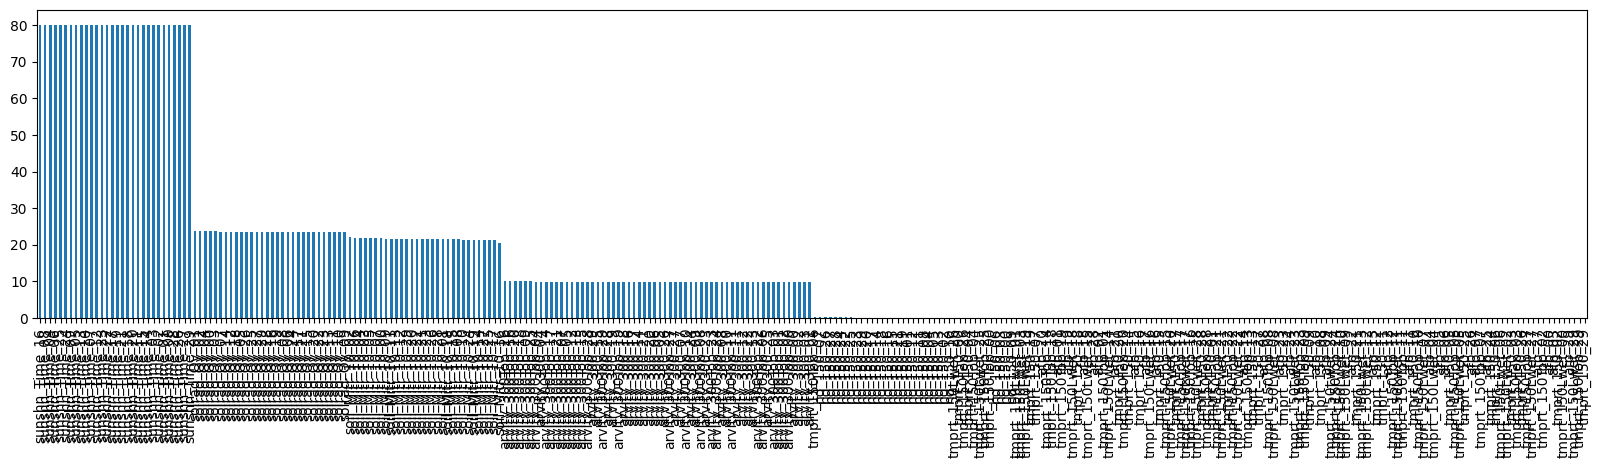

In [ ]:
summarize(X_weather)['Missing Values (%)'].sort_values(ascending=False).plot(kind='bar', figsize=(20,4))

In [ ]:
# Calculate missing value percentages for X_weather
missing_percentage_weather = X_weather.isnull().sum() / len(X_weather) * 100

# Identify columns with missing percentage >= 30% in X_weather
high_missing_cols = missing_percentage_weather[missing_percentage_weather >= 30]

print("Columns in X_weather with >= 30% missing values:")
display(high_missing_cols)

Columns in X_weather with >= 30% missing values:


,0
sunshn_Time_29,80.023937
sunshn_Time_28,80.023937
sunshn_Time_27,80.023937
sunshn_Time_26,80.023937
sunshn_Time_25,80.141322
sunshn_Time_24,80.141322
sunshn_Time_23,80.141322
sunshn_Time_22,80.141322
sunshn_Time_21,80.141322
sunshn_Time_20,80.141322


In [ ]:
# Identify columns containing 'sunshn_Time'
sunshn_cols_to_drop = [col for col in X_weather.columns if 'sunshn_Time' in col]

# Drop these columns from X_weather
X_weather = X_weather.drop(columns=sunshn_cols_to_drop)

print(f"Dropped {len(sunshn_cols_to_drop)} columns containing 'sunshn_Time'.")
print("New X_weather shape:", X_weather.shape)

Dropped 30 columns containing 'sunshn_Time'.
New X_weather shape: (130341, 270)


In [ ]:
summarize(X_weather)

,Data Type,Unique Values,Missing Values (%),Sample Values
tmprt_150_29,float64,245,0.029922,"[-5.4, -2.6, -1.8, -5.5, 0.2, -5.2, -3.3, -4.9..."
tmprt_150Top_29,float64,271,0.029922,"[1.3, 3.0, 2.7, 1.8, 7.6, 1.2, 2.0, 2.8, 7.7, ..."
tmprt_150Lwet_29,float64,252,0.029922,"[-10.6, -7.6, -7.4, -11.6, -5.7, -10.3, -8.8, ..."
hd_150_29,float64,449,0.108945,"[59.3, 55.9, 46.9, 62.1, 66.8, 65.9, 56.5, 67...."
arvlty_300_29,float64,47,9.935477,"[0.3, 0.7, 0.5, 0.2, 0.0, 0.4, 0.6, 0.9, 1.0, ..."
...,...,...,...,...
arvlty_300_00,float64,56,9.914762,"[0.2, 0.6, 0.4, 0.0, 0.3, 0.7, 1.5, 1.1, 0.8, ..."
arvlty_300Top_00,float64,165,9.915529,"[2.8, 6.0, 4.2, 0.0, 7.9, 3.6, 5.1, 7.1, 10.6,..."
afp_00,float64,34,0.032990,"[1.0, 0.5, 0.0, 2.0, 7.0, 2.5, 10.5, 16.5, 8.5..."
solrad_Qy_00,float64,791,23.676357,"[3.99, 6.11, 4.73, 9.52, 4.25, 4.23, 7.0, 13.5..."


In [ ]:
# Get the summary of X_weather
summary_weather = summarize(X_weather)

# Sort the summary DataFrame by index (column names)
summary_weather_sorted = summary_weather.sort_index()

# Display the sorted summary
display(summary_weather_sorted)

,Data Type,Unique Values,Missing Values (%),Sample Values
afp_00,float64,34,0.032990,"[1.0, 0.5, 0.0, 2.0, 7.0, 2.5, 10.5, 16.5, 8.5..."
afp_01,float64,20,0.032990,"[1.0, 0.0, 0.5, 1.5, 5.0, 4.5, 4.0, 10.5, 9.5,..."
afp_02,float64,35,0.032990,"[0.0, 0.5, 1.0, 6.5, 3.5, 1.5, 2.0, 3.0, 2.5, ..."
afp_03,float64,55,0.032990,"[0.5, 0.0, 1.0, 1.5, 6.0, 2.5, 2.0, 5.0, 3.5, ..."
afp_04,float64,26,0.032990,"[0.5, 0.0, 1.5, 4.0, 2.5, 1.0, 2.0, 3.5, 3.0, ..."
...,...,...,...,...
tmprt_150_25,float64,238,0.032990,"[-2.8, 0.1, 0.0, -2.3, 0.4, -4.0, -0.3, -2.4, ..."
tmprt_150_26,float64,233,0.032990,"[-4.6, -2.9, -2.4, -4.8, -1.2, -4.4, -3.4, 3.3..."
tmprt_150_27,float64,238,0.032990,"[-3.4, -2.0, -1.8, -4.0, 1.8, -2.4, -2.3, -1.5..."
tmprt_150_28,float64,240,0.032990,"[0.2, 3.1, 3.3, 1.0, 3.2, -1.4, 0.0, 5.8, 4.8,..."


### 시계열자료 채우기 시간순으로

In [ ]:
# 소팅을 해서 컬럼명이 텍스트가 같은 그룹내에서 날짜순으로 앞뒤로 채우려고
X_weather = X_weather.sort_index(axis=1)
X_weather.head()

,afp_00,afp_01,afp_02,afp_03,afp_04,afp_05,afp_06,afp_07,afp_08,afp_09,...,tmprt_150_20,tmprt_150_21,tmprt_150_22,tmprt_150_23,tmprt_150_24,tmprt_150_25,tmprt_150_26,tmprt_150_27,tmprt_150_28,tmprt_150_29
0,1.0,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,...,-1.5,-1.1,0.8,0.2,2.0,-2.8,-4.6,-3.4,0.2,-5.4
1,1.0,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,...,-1.5,-1.1,0.8,0.2,2.0,-2.8,-4.6,-3.4,0.2,-5.4
2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.8,3.0,1.7,6.0,0.1,-2.9,-2.0,3.1,-2.6
3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.8,3.0,1.7,6.0,0.1,-2.9,-2.0,3.1,-2.6
4,0.0,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,...,1.6,1.4,3.4,2.1,4.1,0.0,-2.4,-1.8,3.3,-1.8


In [ ]:
import re

def fix_nan_auto_group(df):

    '''
    시계열자료 채우기 로직
    '''
    result = df.copy()

    # 컬럼 이름에서 그룹 접두사(e.g., 'wtf', 'vsf')를 자동으로 추출
    # '_01' 과 같은 부분을 제외하고 고유한 그룹 이름을 찾음
    groups = {re.findall(r'(\w+)_', col)[0] for col in df.columns if '_' in col}

    # 각 그룹별로 NaN 값 채우기
    for group_name in groups:
        group_cols = [col for col in df.columns if col.startswith(group_name)]
        # 그룹 내에서 뒤쪽 값으로 먼저 채운 후 앞쪽 값으로 채우기
        result[group_cols] = result[group_cols].bfill(axis=1).ffill(axis=1)

    # 그룹 내에서 채워지지 않은 NaN(행의 양끝)을 0으로 채우기
    result = result.fillna(0)

    return result

In [ ]:
X_weather = fix_nan_auto_group(X_weather)

In [ ]:
X_weather.isnull().sum().sum() # 결측치 없음

np.int64(0)

In [ ]:
summarize(X_weather)

,Data Type,Unique Values,Missing Values (%),Sample Values
afp_00,float64,34,0.0,"[1.0, 0.5, 0.0, 2.0, 7.0, 2.5, 10.5, 16.5, 8.5..."
afp_01,float64,20,0.0,"[1.0, 0.0, 0.5, 1.5, 5.0, 4.5, 4.0, 10.5, 9.5,..."
afp_02,float64,35,0.0,"[0.0, 0.5, 1.0, 6.5, 3.5, 1.5, 2.0, 3.0, 2.5, ..."
afp_03,float64,55,0.0,"[0.5, 0.0, 1.0, 1.5, 6.0, 2.5, 2.0, 5.0, 3.5, ..."
afp_04,float64,26,0.0,"[0.5, 0.0, 1.5, 4.0, 2.5, 1.0, 2.0, 3.5, 3.0, ..."
...,...,...,...,...
tmprt_150_25,float64,239,0.0,"[-2.8, 0.1, 0.0, -2.3, 0.4, -4.0, -0.3, -2.4, ..."
tmprt_150_26,float64,233,0.0,"[-4.6, -2.9, -2.4, -4.8, -1.2, -4.4, -3.4, 3.3..."
tmprt_150_27,float64,238,0.0,"[-3.4, -2.0, -1.8, -4.0, 1.8, -2.4, -2.3, -1.5..."
tmprt_150_28,float64,241,0.0,"[0.2, 3.1, 3.3, 1.0, 3.2, -1.4, 0.0, 5.8, 4.8,..."


### 입력데이터 정리

In [ ]:
# Merge X_weather and X_lims based on their index
X = pd.concat([X_weather, X_lims], axis=1)
print("Shape of the combined DataFrame (X_combined):", X.shape)

Shape of the combined DataFrame (X_combined): (130341, 272)


In [ ]:
y = y_df_filtered.copy()
print("Shape of target:", y.shape)

Shape of target: (130341,)


In [ ]:
summarize(X)

,Data Type,Unique Values,Missing Values (%),Sample Values
afp_00,float64,34,0.0,"[1.0, 0.5, 0.0, 2.0, 7.0, 2.5, 10.5, 16.5, 8.5..."
afp_01,float64,20,0.0,"[1.0, 0.0, 0.5, 1.5, 5.0, 4.5, 4.0, 10.5, 9.5,..."
afp_02,float64,35,0.0,"[0.0, 0.5, 1.0, 6.5, 3.5, 1.5, 2.0, 3.0, 2.5, ..."
afp_03,float64,55,0.0,"[0.5, 0.0, 1.0, 1.5, 6.0, 2.5, 2.0, 5.0, 3.5, ..."
afp_04,float64,26,0.0,"[0.5, 0.0, 1.5, 4.0, 2.5, 1.0, 2.0, 3.5, 3.0, ..."
...,...,...,...,...
tmprt_150_27,float64,238,0.0,"[-3.4, -2.0, -1.8, -4.0, 1.8, -2.4, -2.3, -1.5..."
tmprt_150_28,float64,241,0.0,"[0.2, 3.1, 3.3, 1.0, 3.2, -1.4, 0.0, 5.8, 4.8,..."
tmprt_150_29,float64,245,0.0,"[-5.4, -2.6, -1.8, -5.5, 0.2, -5.2, -3.3, -4.9..."
INSPCT_PURPS_NAME,object,5,0.0,"[자가품질위탁검사, 수거검사, 품질검사, 기타, 모니터링검사]"


In [ ]:
# Create a DataFrame for the target variable y
y = pd.read_pickle('/content/drive/MyDrive/다운사이징.pkl')

# Display the head of the y DataFrame
display(y.head())

,JDGMNT_WORD_NAME_encoded,INSPCT_기타,INSPCT_수거검사,INSPCT_자가품질위탁검사,PRDLST_강황추출물(제2023-5호),PRDLST_고춧가루,PRDLST_곡류가공품,PRDLST_과.채가공품,PRDLST_과자,PRDLST_기타_999,...,PRDLST_우유,PRDLST_천연향신료,PRDLST_초콜릿가공품,PRDLST_침출차,PRDLST_캔디류,PRDLST_한식간장,PRDLST_한식된장,PRDLST_한식메주,PRDLST_혼합간장,PRDLST_효소식품
0,0,False,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0,False,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,False,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Merge X and y based on their index
# Using pd.concat with axis=1 assumes both dataframes have the same index
merged_df = pd.concat([X,y], axis=1, join='inner', ignore_index=False, keys=None)
merged_df.columns

Index(['afp_00', 'afp_01', 'afp_02', 'afp_03', 'afp_04', 'afp_05', 'afp_06',
       'afp_07', 'afp_08', 'afp_09',
       ...
       'PRDLST_우유', 'PRDLST_천연향신료', 'PRDLST_초콜릿가공품', 'PRDLST_침출차',
       'PRDLST_캔디류', 'PRDLST_한식간장', 'PRDLST_한식된장', 'PRDLST_한식메주',
       'PRDLST_혼합간장', 'PRDLST_효소식품'],
      dtype='object', length=306)

### 부적합 비율이 있는 검사의 종류

In [ ]:
# Calculate the mean of JDGMNT_WORD_NAME_encoded, grouped by INSPCT_PURPS_NAME
grouped_mean_by_purpose = merged_df.groupby('INSPCT_PURPS_NAME')['JDGMNT_WORD_NAME_encoded'].mean()

print("Mean of encoded 'JDGMNT_WORD_NAME' by 'INSPCT_PURPS_NAME' (proportion of '부적합'):")
display(grouped_mean_by_purpose)

Mean of encoded 'JDGMNT_WORD_NAME' by 'INSPCT_PURPS_NAME' (proportion of '부적합'):


,JDGMNT_WORD_NAME_encoded
INSPCT_PURPS_NAME,
기타,0.105691
수거검사,0.009476
자가품질위탁검사,0.004240


### 부적합 비율이 있는 가공식품의 종류 (상위분류면이 필요)

In [ ]:
# Calculate the mean of the encoded JDGMNT_WORD_NAME, grouped by PRDLST_NM
grouped_mean_by_prdlst = merged_df.groupby('PRDLST_NM')['JDGMNT_WORD_NAME_encoded'].mean()
# Filter the series to show only the rows where the mean is greater than 0
prdlst_with_failures = grouped_mean_by_prdlst[grouped_mean_by_prdlst > 0]
print("Product Names (PRDLST_NM) with at least one '부적합' case:")
display(prdlst_with_failures)

Product Names (PRDLST_NM) with at least one '부적합' case:


,JDGMNT_WORD_NAME_encoded
PRDLST_NM,
강황추출물(제2023-5호),0.022222
고춧가루,0.014652
곡류가공품,0.007460
과.채가공품,0.002522
과자,0.007485
기타_999,0.004814
기타가공품,0.031250
두류가공품,0.003509
땅콩 또는 견과류 가공품,0.001823


# **2. 예측모형 개발**
### 전처리한(특성변수 추출은 없음) 데이터를 예측모형에 투입
### 2.1. Features and Target

In [ ]:
merged_df.columns

Index(['afp_00', 'afp_01', 'afp_02', 'afp_03', 'afp_04', 'afp_05', 'afp_06',
       'afp_07', 'afp_08', 'afp_09',
       ...
       'PRDLST_우유', 'PRDLST_천연향신료', 'PRDLST_초콜릿가공품', 'PRDLST_침출차',
       'PRDLST_캔디류', 'PRDLST_한식간장', 'PRDLST_한식된장', 'PRDLST_한식메주',
       'PRDLST_혼합간장', 'PRDLST_효소식품'],
      dtype='object', length=306)

In [ ]:
# Create the feature matrix X by dropping the specified columns
X = merged_df.drop(columns=['JDGMNT_WORD_NAME_encoded'])

# Create the target variable y using the encoded column
y = merged_df['JDGMNT_WORD_NAME_encoded']

print("Shape of feature matrix (X):", X.shape)
print("Shape of target variable (y):", y.shape)

Shape of feature matrix (X): (113491, 305)
Shape of target variable (y): (113491,)


In [ ]:
X

,afp_00,afp_01,afp_02,afp_03,afp_04,afp_05,afp_06,afp_07,afp_08,afp_09,...,PRDLST_우유,PRDLST_천연향신료,PRDLST_초콜릿가공품,PRDLST_침출차,PRDLST_캔디류,PRDLST_한식간장,PRDLST_한식된장,PRDLST_한식메주,PRDLST_혼합간장,PRDLST_효소식품
0,1.0,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,1.0,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0.0,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,False
169235,0.0,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
169237,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
170023,0.0,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


1.  **데이터 분리 (`train_test_split`)**
    * 전체 데이터를 학습용(80%)과 테스트용(20%)으로 나눕니다.
    * `stratify=y` 옵션을 사용하여 원본 데이터의 클래스 비율(양성/음성 비율)이 학습 및 테스트 데이터셋에 동일하게 유지되도록 합니다. 이는 불균형 데이터 평가의 신뢰성을 높이는 중요한 단계입니다.

2.  **전처리 파이프라인 구축 (`ColumnTransformer`)**
    * 모델이 데이터를 잘 학습할 수 있도록 변수 유형에 따라 맞춤형 전처리를 정의합니다.
    * **숫자형 변수 (`StandardScaler`)**: 모든 숫자 데이터의 단위를 통일하여 특정 변수가 모델에 과도한 영향을 주는 것을 방지합니다.
    * **문자형 변수 (`OneHotEncoder`)**: 문자 데이터를 모델이 이해할 수 있는 0과 1로 이루어진 숫자 데이터로 변환합니다.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# 1. Train/Test 분리 (먼저 해야 함!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 변수 유형 분리
numerical_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# 전처리 파이프라인
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
import warnings
warnings.filterwarnings('ignore')


3.  **SMOTE 기법 비교를 위한 자동화 (`for` 루프 & `ImbPipeline`)**
    * 비교하려는 4가지 SMOTE 기법(SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN)을 순회하는 반복문을 만듭니다.
    * `ImbPipeline`을 사용하여 **[전처리 → 오버샘플링 → 모델 학습]** 과정을 하나로 묶습니다. 이 파이프라인은 교차 검증 시 학습 데이터에만 오버샘플링을 적용하여 테스트 데이터가 오염되는 것(Data Leakage)을 방지하고 정확한 성능 측정을 보장합니다.

4.  **모델 학습 및 교차 검증 (`RandomizedSearchCV`)**
    * 각 SMOTE 기법에 대해 5-겹 교차 검증(`StratifiedKFold`)을 수행하여 모델의 안정적인 성능을 평가합니다.
    * `scoring='recall'`로 설정하여, 불균형 데이터에서 특히 중요한 소수 클래스(양성)를 얼마나 잘 찾아내는지를 기준으로 모델을 평가합니다.
    * `RandomizedSearchCV`를 사용했지만, 하이퍼파라미터(`param_distributions`)를 지정하지 않았기 때문에 이 코드에서는 사실상 교차 검증을 통한 기본 모델 성능 평가 역할만 수행합니다.

5.  **결과 취합 및 비교**
    * 각 SMOTE 기법으로 학습된 최적의 모델을 사용하여 분리해 두었던 테스트 데이터셋으로 최종 성능을 평가합니다.
    * 평가 점수를 `results` 딕셔너리에 저장하고, 마지막에 모든 기법의 성능을 한눈에 비교할 수 있도록 요약하여 출력합니다.

In [ ]:
# 사용할 SMOTE 기법들
smote_methods = {
    "SMOTE": SMOTE(random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=42),
    "SVMSMOTE": SVMSMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42)
}

# 결과 저장용
results = {}

# 반복문으로 각 SMOTE 기법 적용
for name, smote in smote_methods.items():
    print(f"\n=== Running with {name} ===")

    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        ))
    ])

    # 교차 검증 설정
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 하이퍼파라미터 튜닝 (너무 오래 걸리지 않게 기본값)
    param_distributions = {}  # 지금은 비워둠

    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        n_iter=10,  # param_distributions 비워둔 경우 의미 없음
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    random_search.fit(X_train, y_train)

    # 성능 기록
    score = random_search.best_estimator_.score(X_test, y_test)
    results[name] = score
    print(f"{name} Test Score: {score:.4f}")

# 최종 결과 비교
print("\n=== Summary of SMOTE methods ===")
for method, score in results.items():
    print(f"{method}: {score:.4f}")


=== Running with SMOTE ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SMOTE Test Score: 0.9277

=== Running with BorderlineSMOTE ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
BorderlineSMOTE Test Score: 0.9732

=== Running with SVMSMOTE ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVMSMOTE Test Score: 0.9743

=== Running with ADASYN ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ADASYN Test Score: 0.9257

=== Summary of SMOTE methods ===
SMOTE: 0.9277
BorderlineSMOTE: 0.9732
SVMSMOTE: 0.9743
ADASYN: 0.9257


# 기존 교수님코드에서 수정점
1. train_test_split: 전체 데이터에서 20%는 Test로 분리 → 성능 평가용.

2. 여러 SMOTE 기법 비교: for 반복문으로 돌면서 각각 Recall 중심 성능 측정.

3. 결과 기록: results 딕셔너리에 SMOTE 기법별 Test 성능 저장 및 출력.

### 2.3. 결과 확인
튜닝이 완료된 후, 최적의 하이퍼파라미터와 교차 검증 결과를 확인합니다.


DETAILED EVALUATION FOR EACH SMOTE METHOD

==================== SMOTE DETAILED ANALYSIS ====================

📊 Classification Report for SMOTE:
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     22587
           1       0.03      0.43      0.06       112

    accuracy                           0.93     22699
   macro avg       0.51      0.68      0.51     22699
weighted avg       0.99      0.93      0.96     22699

🎯 ROC AUC Score: 0.8540
🎯 Average Precision Score: 0.0788

==================== BorderlineSMOTE DETAILED ANALYSIS ====================

📊 Classification Report for BorderlineSMOTE:
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     22587
           1       0.04      0.18      0.06       112

    accuracy                           0.97     22699
   macro avg       0.52   

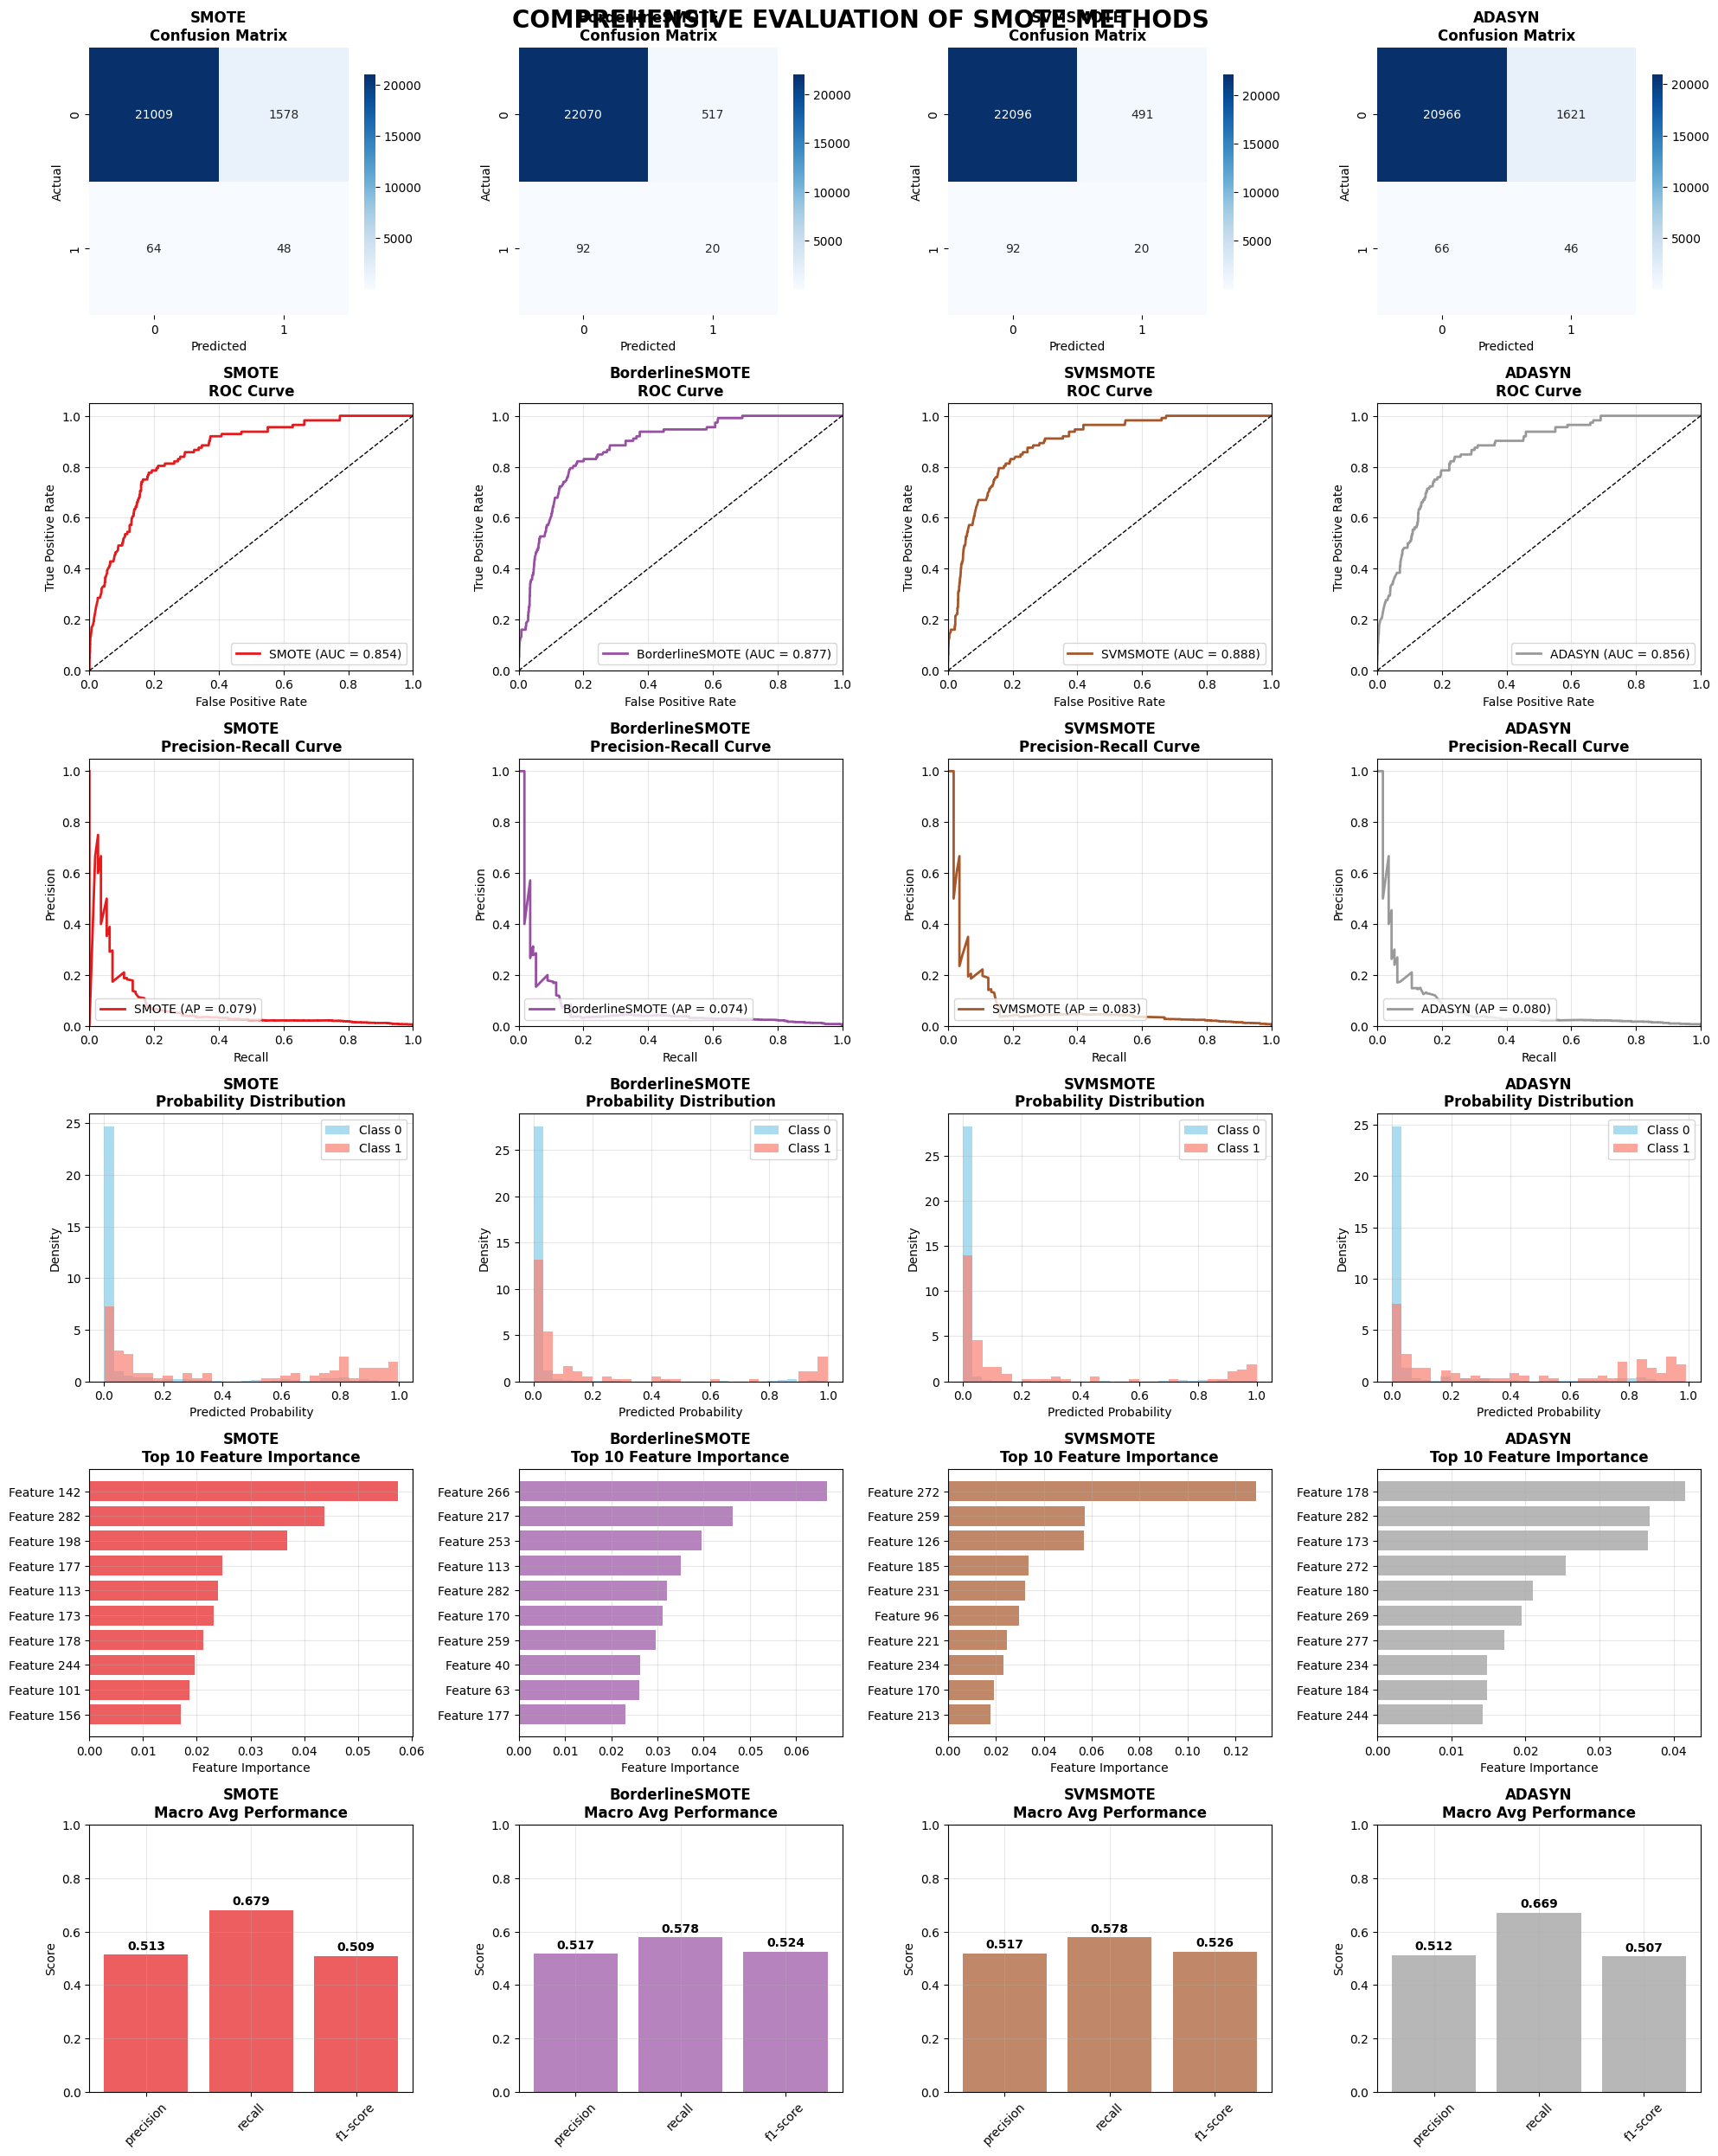


📈 COMPREHENSIVE PERFORMANCE COMPARISON
         Method  ROC AUC  Avg Precision  Macro Precision  Macro Recall  Macro F1
          SMOTE   0.8540         0.0788           0.5132        0.6794    0.5088
BorderlineSMOTE   0.8767         0.0741           0.5165        0.5778    0.5240
       SVMSMOTE   0.8881         0.0827           0.5175        0.5784    0.5256
         ADASYN   0.8564         0.0798           0.5122        0.6695    0.5065

🏆 BEST PERFORMING METHODS:
   • Best ROC AUC: SVMSMOTE (0.8881)
   • Best Macro F1: SVMSMOTE (0.5256)
   • Best Avg Precision: SVMSMOTE (0.0827)

ANALYSIS COMPLETE! 🎉


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (선택사항)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (15, 10)

# 결과 저장용 딕셔너리 확장
detailed_results = {}

print("\n" + "="*80)
print("DETAILED EVALUATION FOR EACH SMOTE METHOD")
print("="*80)

# 각 SMOTE 방법별로 상세 평가
for name, smote in smote_methods.items():
    print(f"\n{'='*20} {name} DETAILED ANALYSIS {'='*20}")

    # 파이프라인 재구성
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        ))
    ])

    # 학습 및 예측
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # 1. Classification Report
    print(f"\n📊 Classification Report for {name}:")
    print("-" * 50)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    # 2. 각종 메트릭 계산
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    # 결과 저장
    detailed_results[name] = {
        'pipeline': pipeline,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'classification_report': report,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision
    }

    print(f"🎯 ROC AUC Score: {roc_auc:.4f}")
    print(f"🎯 Average Precision Score: {avg_precision:.4f}")

# 시각화
n_methods = len(smote_methods)
fig = plt.figure(figsize=(20, 25))

# 색상 팔레트 설정
colors = plt.cm.Set1(np.linspace(0, 1, n_methods))

for idx, (name, results_data) in enumerate(detailed_results.items()):
    y_pred = results_data['y_pred']
    y_pred_proba = results_data['y_pred_proba']
    color = colors[idx]

    # 1. Confusion Matrix
    plt.subplot(6, n_methods, idx + 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar_kws={'shrink': 0.8})
    plt.title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 2. ROC Curve
    plt.subplot(6, n_methods, n_methods + idx + 1)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name}\nROC Curve', fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)

    # 3. Precision-Recall Curve
    plt.subplot(6, n_methods, 2*n_methods + idx + 1)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    plt.plot(recall, precision, color=color, lw=2,
             label=f'{name} (AP = {avg_precision:.3f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name}\nPrecision-Recall Curve', fontweight='bold')
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(True, alpha=0.3)

    # 4. Predicted Probability Distribution
    plt.subplot(6, n_methods, 3*n_methods + idx + 1)
    # 클래스별 확률 분포
    prob_class_0 = y_pred_proba[y_test == 0]
    prob_class_1 = y_pred_proba[y_test == 1]

    plt.hist(prob_class_0, bins=30, alpha=0.7, label='Class 0',
             color='skyblue', density=True)
    plt.hist(prob_class_1, bins=30, alpha=0.7, label='Class 1',
             color='salmon', density=True)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title(f'{name}\nProbability Distribution', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Feature Importance (XGBoost의 경우)
    plt.subplot(6, n_methods, 4*n_methods + idx + 1)
    try:
        # 전처리된 특성 이름 생성
        feature_names = []
        if len(numerical_features) > 0:
            feature_names.extend([f'num_{col}' for col in numerical_features])
        if len(categorical_features) > 0:
            # OneHotEncoder로 인한 확장된 특성명은 간단히 처리
            feature_names.extend([f'cat_{i}' for i in range(len(categorical_features)*10)])  # 대략적 추정

        classifier = results_data['pipeline'].named_steps['classifier']
        importances = classifier.feature_importances_

        # 상위 10개 특성만 표시
        top_indices = np.argsort(importances)[-10:]
        top_importances = importances[top_indices]

        plt.barh(range(len(top_importances)), top_importances, color=color, alpha=0.7)
        plt.xlabel('Feature Importance')
        plt.title(f'{name}\nTop 10 Feature Importance', fontweight='bold')
        plt.yticks(range(len(top_importances)), [f'Feature {i}' for i in top_indices])
        plt.grid(True, alpha=0.3)
    except Exception as e:
        plt.text(0.5, 0.5, f'Feature importance\nnot available\n({str(e)[:30]}...)',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'{name}\nFeature Importance', fontweight='bold')

    # 6. 성능 메트릭 바차트
    plt.subplot(6, n_methods, 5*n_methods + idx + 1)
    report = results_data['classification_report']
    metrics = ['precision', 'recall', 'f1-score']

    # 클래스별 성능 (매크로 평균 사용)
    macro_scores = [report['macro avg'][metric] for metric in metrics]

    bars = plt.bar(metrics, macro_scores, color=[color]*3, alpha=0.7)
    plt.ylim([0, 1])
    plt.ylabel('Score')
    plt.title(f'{name}\nMacro Avg Performance', fontweight='bold')
    plt.xticks(rotation=45)

    # 바 위에 값 표시
    for bar, score in zip(bars, macro_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('COMPREHENSIVE EVALUATION OF SMOTE METHODS',
             fontsize=20, fontweight='bold', y=0.995)
plt.show()

# 종합 성능 비교표 출력
print("\n" + "="*80)
print("📈 COMPREHENSIVE PERFORMANCE COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Method': list(detailed_results.keys()),
    'ROC AUC': [detailed_results[method]['roc_auc'] for method in detailed_results.keys()],
    'Avg Precision': [detailed_results[method]['avg_precision'] for method in detailed_results.keys()],
    'Macro Precision': [detailed_results[method]['classification_report']['macro avg']['precision']
                       for method in detailed_results.keys()],
    'Macro Recall': [detailed_results[method]['classification_report']['macro avg']['recall']
                    for method in detailed_results.keys()],
    'Macro F1': [detailed_results[method]['classification_report']['macro avg']['f1-score']
                for method in detailed_results.keys()]
})

# 소수점 4자리로 반올림
comparison_df = comparison_df.round(4)
print(comparison_df.to_string(index=False))

# 최고 성능 방법 찾기
best_roc_auc = comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Method']
best_f1 = comparison_df.loc[comparison_df['Macro F1'].idxmax(), 'Method']
best_precision = comparison_df.loc[comparison_df['Avg Precision'].idxmax(), 'Method']

print(f"\n🏆 BEST PERFORMING METHODS:")
print(f"   • Best ROC AUC: {best_roc_auc} ({comparison_df['ROC AUC'].max():.4f})")
print(f"   • Best Macro F1: {best_f1} ({comparison_df['Macro F1'].max():.4f})")
print(f"   • Best Avg Precision: {best_precision} ({comparison_df['Avg Precision'].max():.4f})")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE! 🎉")
print(f"{'='*80}")

- 부적합 사례를 하나라도 더 찾아내는 것이 중요하다면, 기본 SMOTE 방식이 가장 효과적

- 전반적인 성능(ROC AUC, Macro F1)에서는 SVMSMOTE가 가장 우수